# Introduction
In this project we are going to analyze 'Brain Tumor' MRI dataset from Kaggle, create custom function and Convolutional neural network model that predicts brain tumor type from given MRI.
#### This project inludes:
- Image data analysis
- Preprocessing data
- Creating neural network model

In [91]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sb
import os

# I Data preview
#### Step 1 - Resolution
We're going to iterate through whole dataset to extract images aspect ratio.

In [92]:
import os
from PIL import Image

# iterating through data path to generate images resolutions and check aspect ratio
def check_image_resolutions(directory):
    non_square_imgs = 0
    square_imgs = 0
    img_res = []
    
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            
            with Image.open(file_path) as img:
                width, height = img.size
                # img_res.append(img.size)
                img_res.append(img.size)
                
                if width / height != 1:
                    non_square_imgs += 1
                else:
                    square_imgs += 1
    
    print(f'1:1 ratio count: {square_imgs}\n'
          f'other ratio count: {non_square_imgs}')

directory_path = 'data'
check_image_resolutions(directory_path)

1:1 ratio count: 5415
other ratio count: 1608


Basing on this information we apply _crop_to_aspect_ratio_ value to _True_, otherwise our images will get stretched or squished.

In [93]:
data = tf.keras.utils.image_dataset_from_directory('data\\Training', batch_size=8, color_mode='grayscale', crop_to_aspect_ratio=True)
class_names = data.class_names
class_names

Found 5712 files belonging to 4 classes.


['glioma', 'meningioma', 'notumor', 'pituitary']

In [94]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

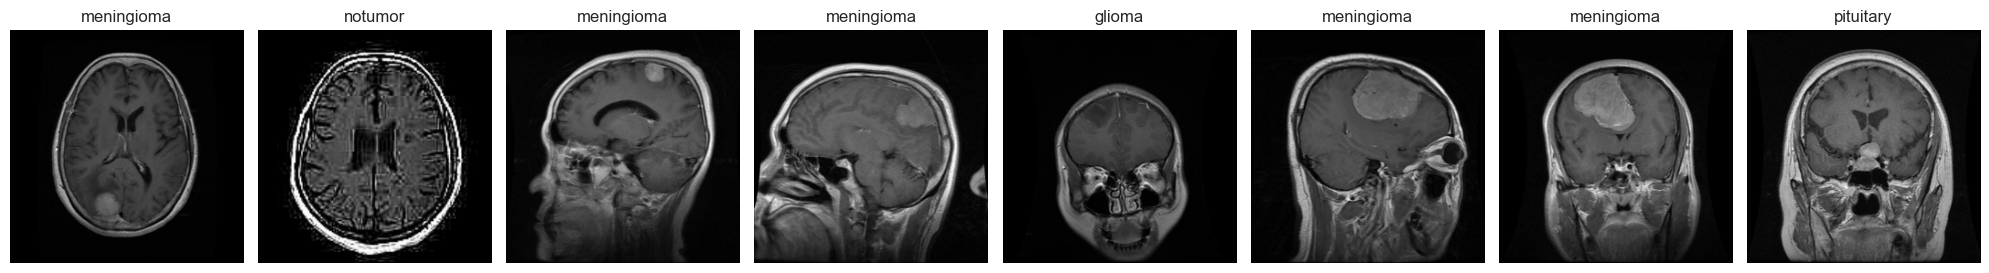

In [95]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(20,10))
for i, img in enumerate(batch[0][:8]):
    class_name = class_names[batch[1][i]]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_name)
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()

Our dataset contains mostly 512px x 512px images and each pixel has 3 channels so basically each image contains **786 432** values,
<br>
by using *color_mode = 'grayscale'* we reduce it to **262 144**,
<br>
additionally Keras automatically downsized our images to 256px x 256px, so we end up with **65 536** values per image.

# II Feature scaling
Scaling our values from range (0, 255) to (0, 1) will help our optimization algorithm (Adam).
<br><br>
x = image values
<br> 
y = labels

In [96]:
print(batch[0].min(), batch[0].max(), sep='\n')

0.0
255.0


In [97]:
data = data.map(lambda x, y: (x/255, y))

In [98]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

min_value = data_iterator.next()[0].min()
max_value = data_iterator.next()[0].max()

print(min_value, max_value, sep='\n')

0.0
0.99146944


Checking black/white balance in images. For selecting reference point on scale I used harmonic mean because it favortise lower values.
<br>
Every point on the plot is a single image, we can see that most of images hang around ratio of 0.19

          Mean: 0.2203136384487152
 Harmonic mean: 0.19813476502895355


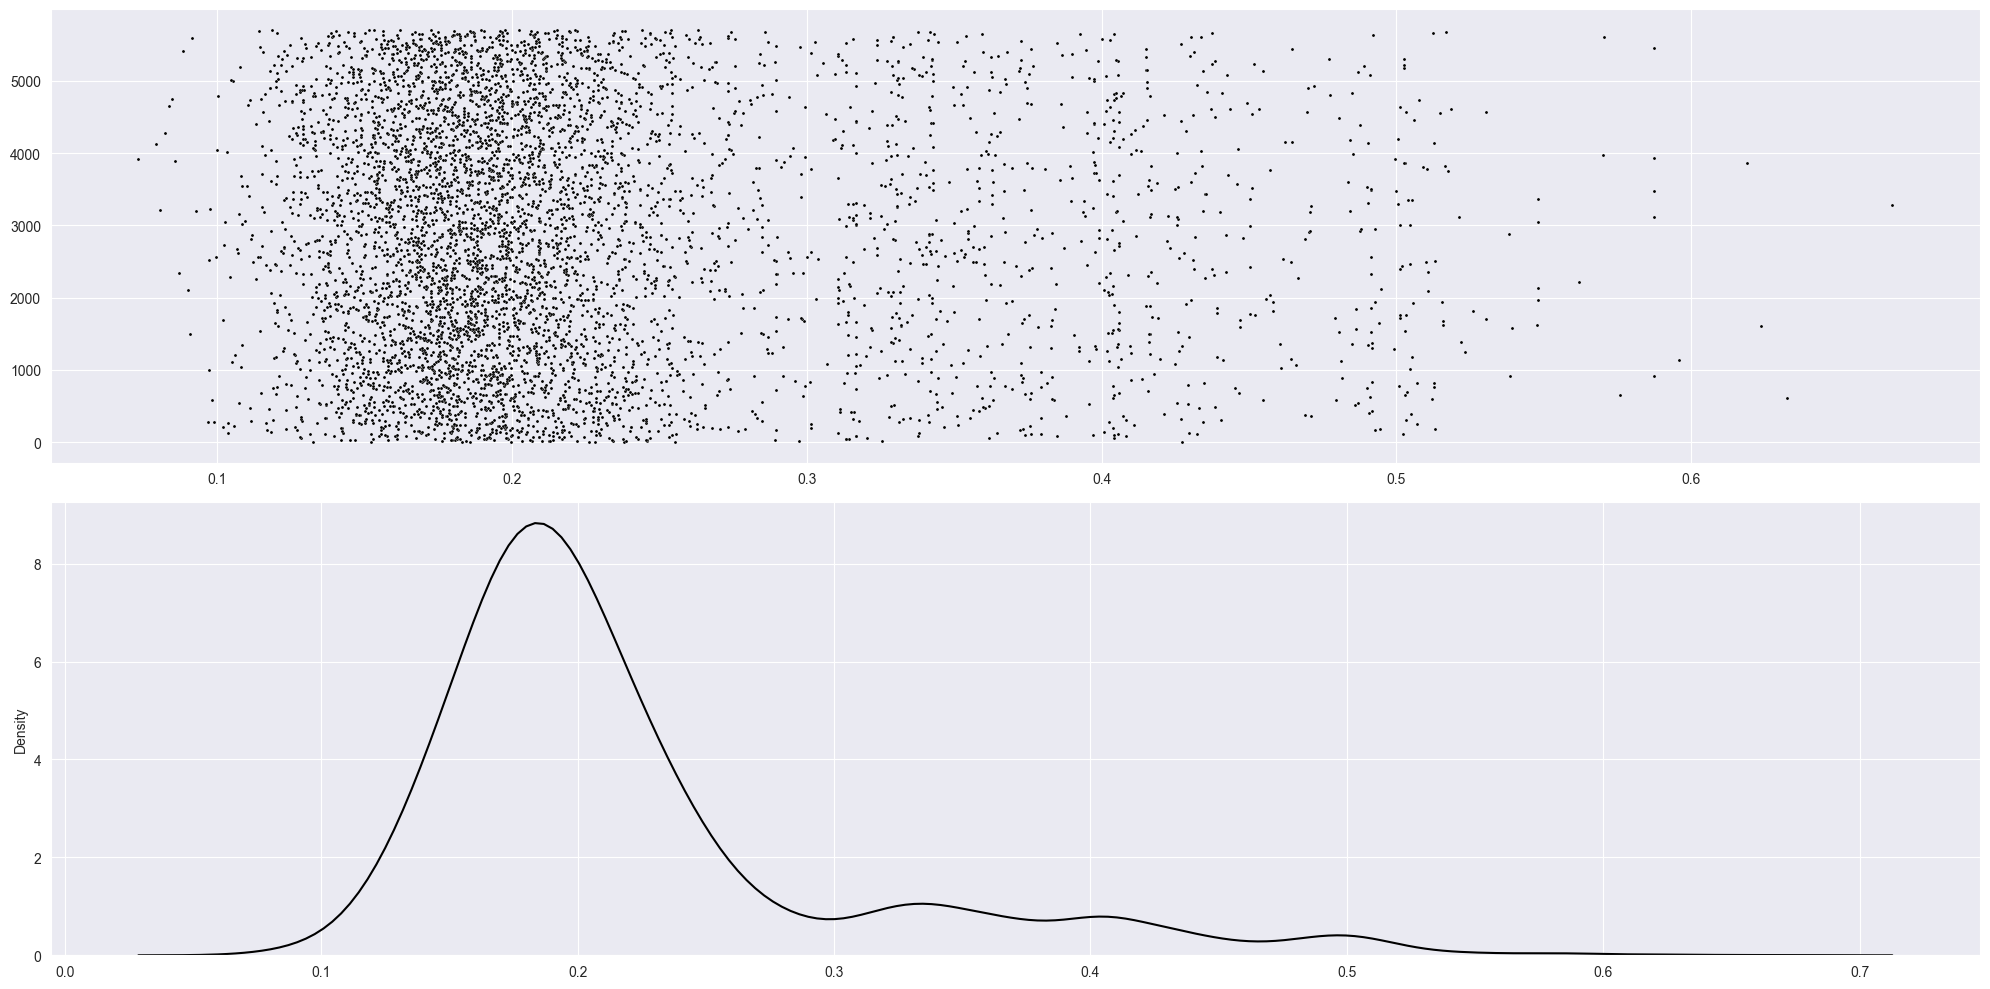

In [99]:
from scipy.stats.mstats import hmean

all_images = []
for images, label in data:
    all_images.append(images.numpy())

all_images = np.concatenate(all_images, axis=0)
# skipping value 0 because it's background and it will lower our mean
all_means = [x[x != 0].mean() for x in all_images]

print(f'{'Mean':>14}: {np.mean(all_means)}\n'
      f'{'Harmonic mean':>14}: {hmean(all_means)}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sb.scatterplot(y=[x for x in range(len(all_means))], x=all_means, color='black', s=5, ax=axes[0])
sb.kdeplot(x=all_means, color='black', ax=axes[1])
plt.tight_layout()

In [100]:
def scale_to_target(batch, target=0.5, multiplier=1):
    f"""
    This function scales image values inside given array to achieve mean value that equals target value.\n
    mean of array => target\n
    array - the array to be scaled\n
    target - value that we want our mean of given array to become\n
    multiplier - % of effect, 0.5 is basically mean of our array mean and target value
    """
    def scale_single_image(img):
        current_mean = tf.reduce_mean(img)
        new_mean = current_mean + (multiplier * (target - current_mean))
        scale_factor = new_mean / current_mean if current_mean != 0 else tf.cast(0, dtype=new_mean.dtype)
        return img * scale_factor

    scaled_batch = tf.map_fn(scale_single_image, batch)
    return scaled_batch


Testing functionality of _scale_to_target_.

In [101]:
ref_point = hmean(all_means)
data_copy = data.skip(1)
scaled_data = data_copy.map(lambda x, y: (scale_to_target(x, target=0.5, multiplier=1), y))

In [102]:
i = 0
for images, labels in scaled_data:
    for img in images:
        if i > 10:
            break
        print(tf.reduce_mean(img))
        i += 1

tf.Tensor(0.50000036, shape=(), dtype=float32)
tf.Tensor(0.5000003, shape=(), dtype=float32)
tf.Tensor(0.50000024, shape=(), dtype=float32)
tf.Tensor(0.50000036, shape=(), dtype=float32)
tf.Tensor(0.49999997, shape=(), dtype=float32)
tf.Tensor(0.5000002, shape=(), dtype=float32)
tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor(0.50000024, shape=(), dtype=float32)
tf.Tensor(0.5000004, shape=(), dtype=float32)
tf.Tensor(0.5, shape=(), dtype=float32)
tf.Tensor(0.50000036, shape=(), dtype=float32)


In [89]:
ref_point = hmean(all_means)
data = data.map(lambda x, y: (scale_to_target(x, target=ref_point, multiplier=0.5), y))

          Mean: 0.2203136384487152
 Harmonic mean: 0.19813476502895355


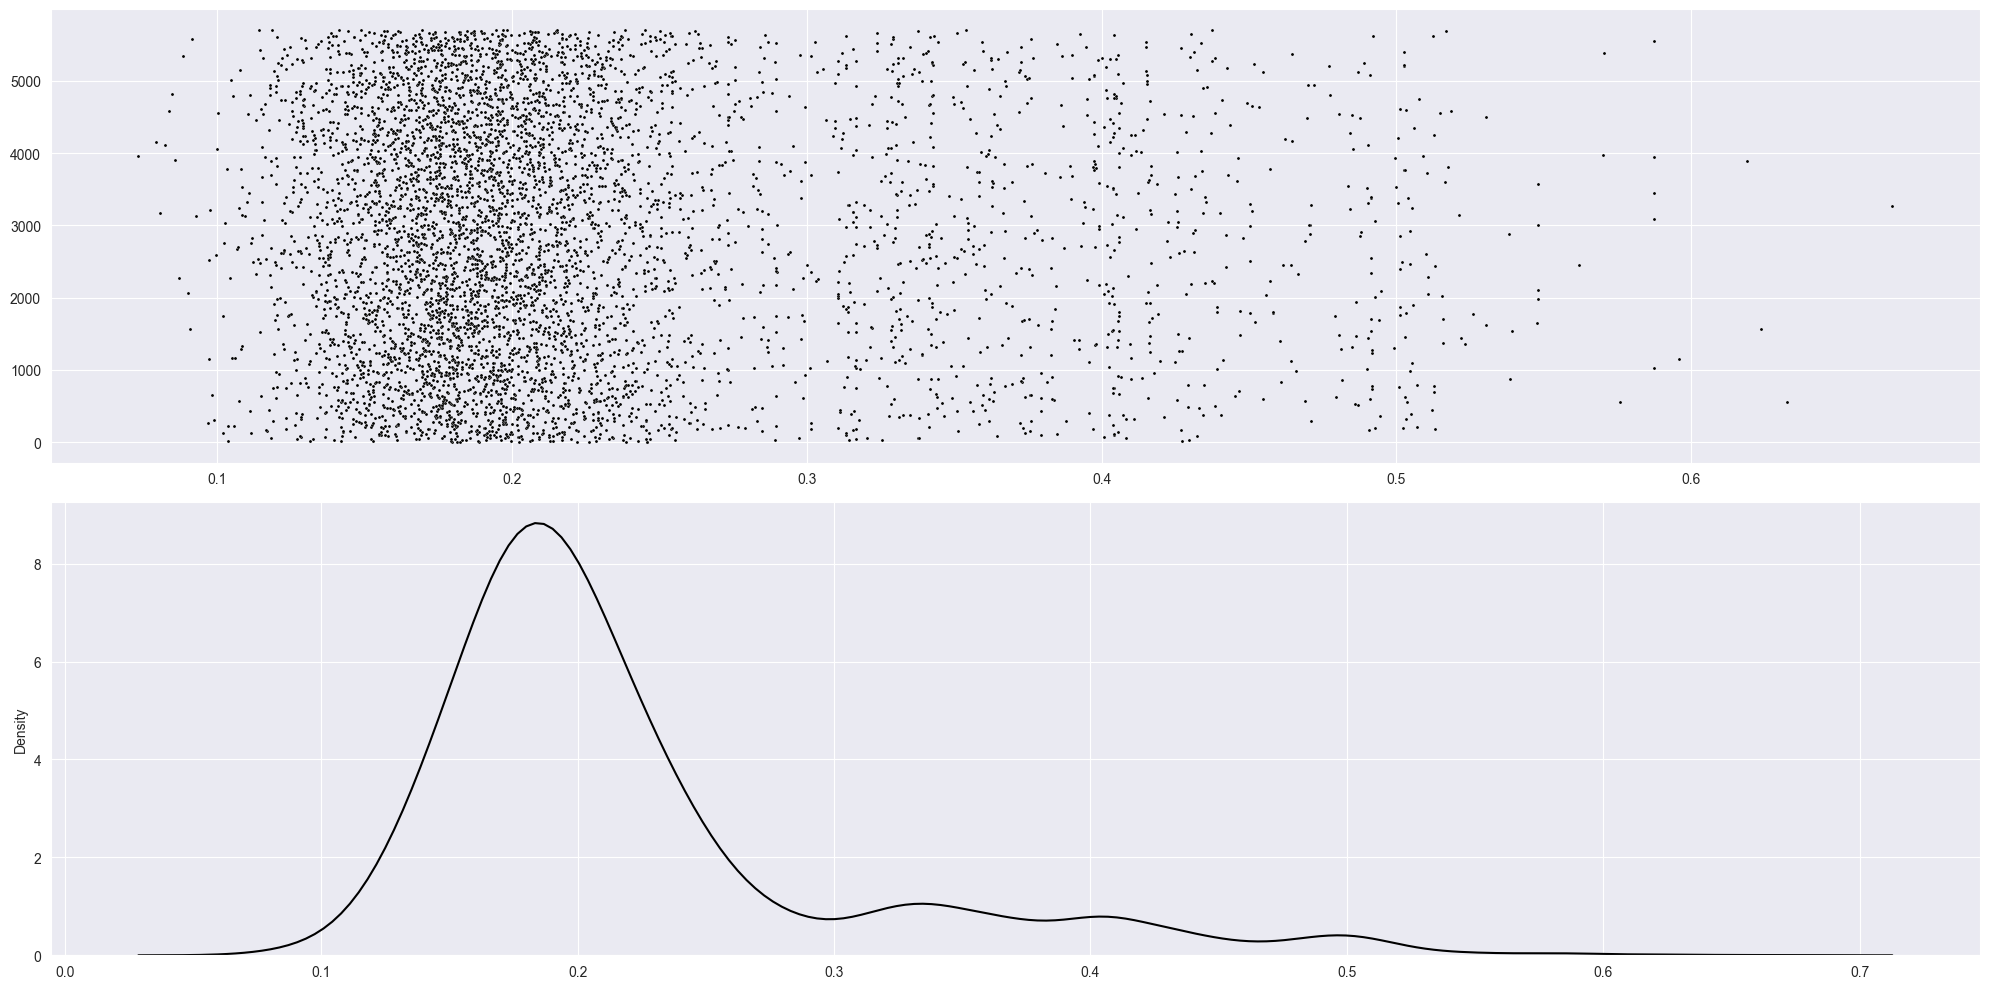

In [103]:
from scipy.stats.mstats import hmean

all_images = []
for images, label in data:
    all_images.append(images.numpy())

all_images = np.concatenate(all_images, axis=0)
# iterating through all images and taking mean value, skipping value 0 because it's background and it will lower our average
all_means = [x[x != 0].mean() for x in all_images]

print(f'{'Mean':>14}: {np.mean(all_means)}\n'
      f'{'Harmonic mean':>14}: {hmean(all_means)}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sb.scatterplot(y=[x for x in range(len(all_means))], x=all_means, color='black', s=5, ax=axes[0])
sb.kdeplot(x=all_means, color='black', ax=axes[1])
plt.tight_layout()

# III Creating CNN Model
- In short convolutional neural network base on layers that convolve input matrix (image) through filter matrices resulting filtered output.
<br>
- As input shape we apply values that corresponds to:
    - width = 256
    - height = 256
    - channel = 1 (we use grayscaled images).
<br>
- __*ReLU*__ activation function cleans our output from all unecesary negative values, replacing them with zeros that came from filter multiplication.
<br>
- Since our dataset contain 4 classes I applied __*softmax*__ activation to last step.

In [497]:
train_batch_size = round(len(data) * 0.8)
val_batch_size = round(len(data) * 0.2)

len(data) == train_batch_size + val_batch_size

True

In [498]:
train = data.take(train_batch_size)
val = data.skip(train_batch_size).take(val_batch_size)

print(
    f"train: {len(train)} batches\nval: {len(val)} batches"
)

train: 571 batches
val: 143 batches


In [499]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

In [500]:
def create_model(num_layers = 1, num_filters = 16, kernel_size = 3, regulate = 0.0001, learning_rate = 0.001):
    
    model = Sequential()
    
    model.add(Input(shape=(256, 256, 1)))
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters*2, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(regulate)))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [501]:
test_model = create_model(regulate=0.0001, learning_rate=0.0001)
test_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,108 (14.10 MB)

 Trainable params: 3,697,108 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [502]:
hist = test_model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 50s 85ms/step - accuracy: 0.5076 - loss: 1.1237 - val_accuracy: 0.7614 - val_loss: 0.6834
Epoch 2/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.7502 - loss: 0.6547 - val_accuracy: 0.8330 - val_loss: 0.5157
Epoch 3/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.8150 - loss: 0.5165 - val_accuracy: 0.8497 - val_loss: 0.4492
Epoch 4/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.8545 - loss: 0.4285 - val_accuracy: 0.8645 - val_loss: 0.3888
Epoch 5/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.8630 - loss: 0.3967 - val_accuracy: 0.8733 - val_loss: 0.3648
Epoch 6/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 48s 84ms/step - accuracy: 0.8932 - loss: 0.3426 - val_accuracy: 0.9003 - val_loss: 0.3171
Epoch 7/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.9098 - loss: 0.2890 - val_accuracy: 0.8855 - val_loss: 0.3195
Epoch 8/20
571/571 ━━━━━━━━━━━━━━━━━━━━ 51s 89ms/step - accuracy: 0.9157 - loss: 0.2733 - 

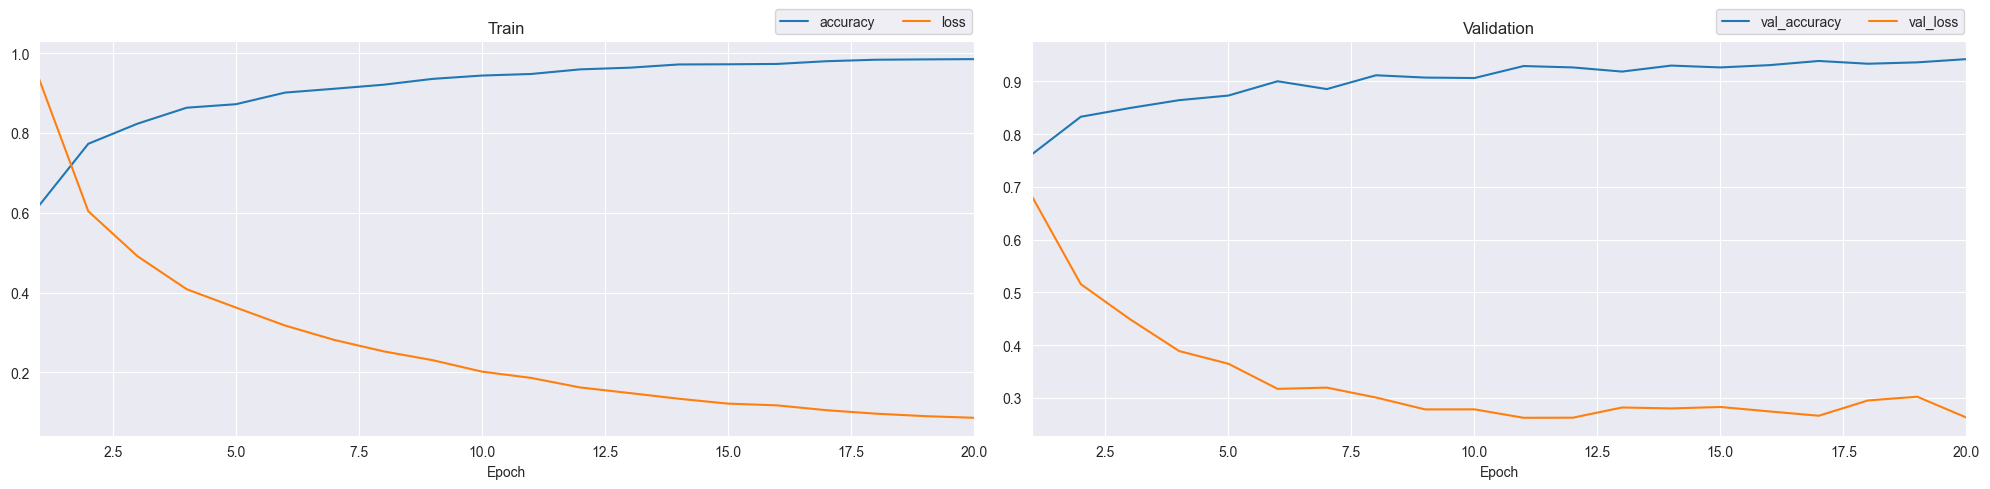

In [503]:
acc_labels = list(hist.history.keys())

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
for i in range(4):
    fig = sb.lineplot(y=hist.history[acc_labels[i]], x=[x for x in range(1, 21, 1)], label=acc_labels[i], ax=axes[i//2])
    axes[i//2].legend(loc='lower right', bbox_to_anchor=(1.005, 1), ncol=2)

axes[0].set_title('Train')
axes[0].set_xlabel('Epoch')
axes[0].set_xlim([1, 20])

axes[1].set_title('Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_xlim([1, 20])

plt.tight_layout()
plt.show()

In [515]:
test_data = tf.keras.utils.image_dataset_from_directory('data\\Testing', batch_size=8, color_mode='grayscale')

Found 1311 files belonging to 4 classes.


In [516]:
test_data = test_data.map(lambda x, y: (x/255, y))

In [517]:
# test_data_mean = hmean()
test_data = test_data.map(lambda x, y: (scale_to_target(x, target=ref_point, multiplier=0.75), y))

In [518]:
y_true = []
y_pred = []

for batch_images, batch_labels in test_data:
    y_true_batch = batch_labels
    y_pred_batch = np.argmax(test_model.predict(batch_images, verbose=0), axis=1)

    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)

              precision    recall  f1-score   support

      glioma       0.94      0.90      0.92       300
  meningioma       0.85      0.80      0.82       306
     notumor       0.91      0.97      0.94       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.92      0.92      1311



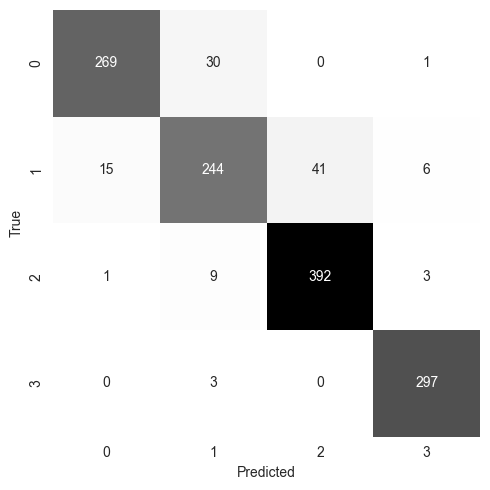

In [519]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_true, y_pred, target_names=class_names)
print(report)
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig = plt.figure(figsize=(5, 5))
fig = sb.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greys')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

0.15413964


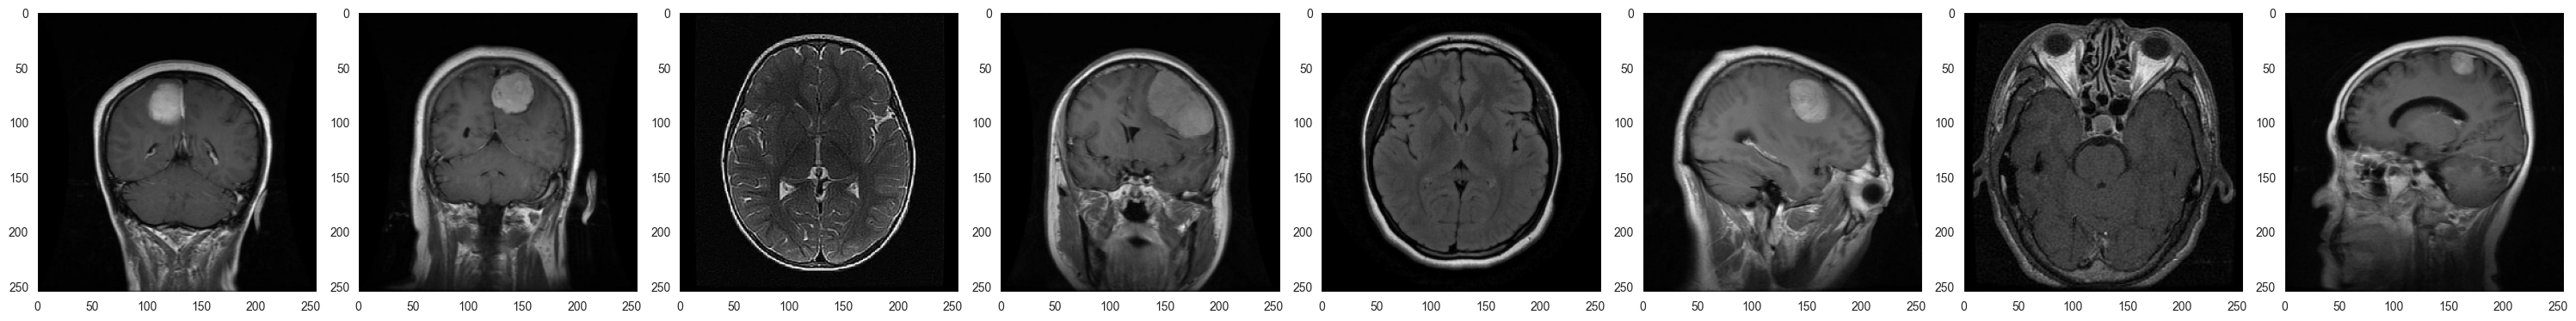

In [131]:
import matplotlib.pyplot as plt

def plot_images(images, labels=None, title="Images"):
    batch_size = images.shape[0]
    plt.figure(figsize=(30, 5))

    for i in range(batch_size):
        plt.subplot(1, batch_size, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='grey')  # Use `squeeze` for grayscale images
        plt.grid(False)
        # if labels is not None:
        #     plt.title(class_names[i])

    plt.tight_layout()
    plt.show()

# Extract a single batch from the scaled dataset
    
for img_batch, label_batch in data.take(1):
    print(np.mean(img_batch))
    plot_images(img_batch, label_batch, title="Rescaled Images")


0.5000001


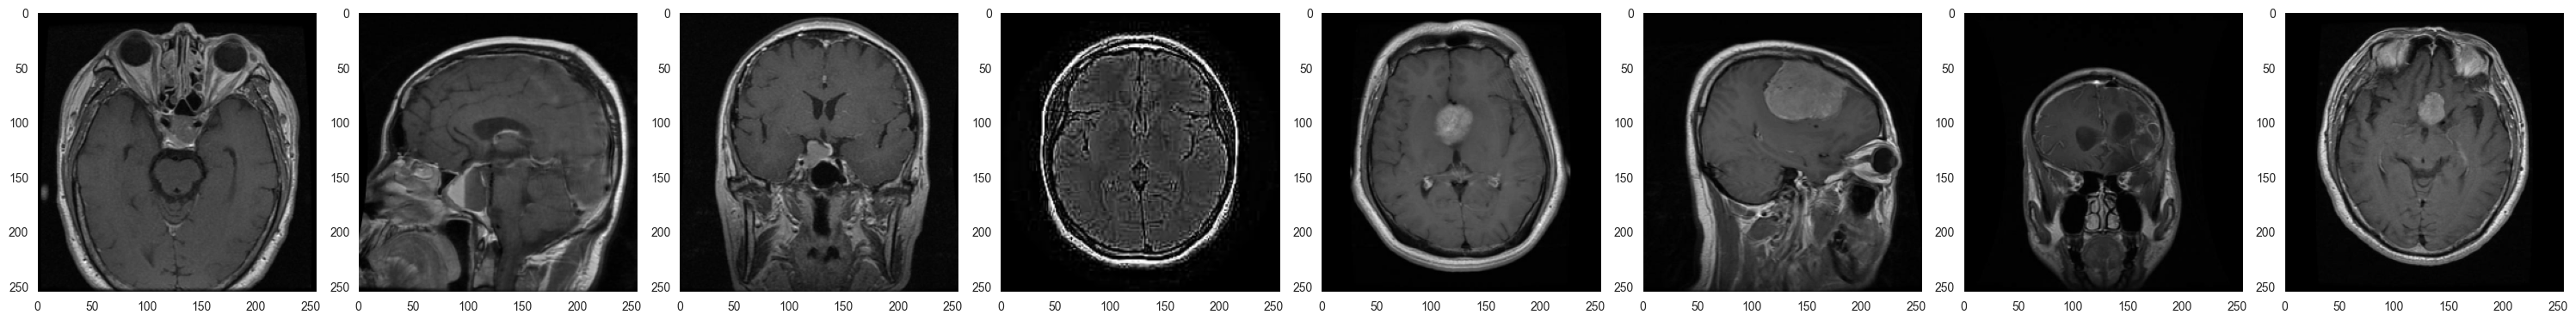

In [132]:
import matplotlib.pyplot as plt

def plot_images(images, labels=None, title="Images"):
    batch_size = images.shape[0]
    plt.figure(figsize=(30, 5))

    for i in range(batch_size):
        plt.subplot(1, batch_size, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='grey')  # Use `squeeze` for grayscale images
        plt.grid(False)
        # if labels is not None:
        # plt.title(labels[i])

    plt.tight_layout()
    plt.show()

# Extract a single batch from the scaled dataset
for img_batch, label_batch in scaled_data.take(1):
    print(np.mean(img_batch))
    plot_images(img_batch, label_batch, title="Rescaled Images")
